### Notebook 3

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
load_dotenv()
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
import xgboost

scope = "user-library-read"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [2]:
def song_to_df (sp, key):
    cat_cols = ['key', 'mode', 'time_signature']
    num_cols = ['danceability','energy','loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo','duration_ms']
    
    row = pd.DataFrame(sp.audio_features(key)).drop(['type','uri',
                                               'track_href','analysis_url'], axis=1).set_index('id')
    return row

def make_genre_prediction(sp,key, ohe, model):
    cat_cols = ['key', 'mode', 'time_signature']
    num_cols = ['danceability','energy','loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo','duration_ms']
    row = song_to_df(sp,key)
    temp_ohe = ohe.transform(row[cat_cols])
    returning_obj = row[num_cols].reset_index().join(pd.DataFrame(temp_ohe)).set_index('id')
    return model.predict(returning_obj)

def song_artist_from_key(sp,key):
    theTrack = sp.track(key)
    song_title = theTrack['name']
    artist_title = theTrack['artists'][0]['name']
    song_link = theTrack['external_urls']['spotify']
    return (song_title, artist_title, song_link)


def song_id_from_query(sp, query):
    q = query
    if(sp.search(q, limit=1, offset=0, type='track')['tracks']['total']>0):
        return sp.search( q, limit=1, offset=0, type='track')['tracks']['items'][0]['id']
    else:
        return None

In [3]:
infile = open('pickled_files/all_songs_genre_predicted.pickle','rb')
all_files = pickle.load(infile)
infile.close()
# df.set_index('id', inplace = True)
all_songs = all_files[0]
best_model = all_files[1]
ohe_make_genre_pred = all_files[2]

In [4]:
categorical_columns = list(all_songs.select_dtypes('object').columns)
numerical_columns = list(all_songs.select_dtypes(exclude = 'object').columns)

In [5]:
all_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,predicted_genre
id,,,,,,,,,,,,,,
3AfajMb3XqqpE97TudO1ab,0.253,0.888,4,-4.592,0,0.0787,0.000225,0.013200,0.9960,0.195,105.763,373800.0,4,alt-metal
4voEoczU7Ijborps9XF1n3,0.846,0.416,10,-13.767,0,0.1180,0.156000,0.000009,0.2380,0.645,96.188,259000.0,4,hip-hop
3iD2CCv5bsJRIaqJRYD0uJ,0.381,0.162,5,-12.440,1,0.0295,0.880000,0.000000,0.0882,0.345,96.744,125533.0,4,rock
7rRLVR3QZOGPkNckz4DSAc,0.521,0.881,10,-5.417,0,0.0850,0.000922,0.035100,0.0976,0.377,150.151,250107.0,3,alt-metal
23SDAWj9QEg7KEB77MMFPf,0.844,0.809,2,-7.320,1,0.0476,0.002020,0.759000,0.0984,0.753,108.343,212467.0,4,hip-hop


In [6]:
import seaborn as sns

In [7]:
pd.get_dummies(all_songs).corr()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,mode_0,mode_1,time_signature_1,time_signature_3,time_signature_4,time_signature_5,predicted_genre_alt-metal,predicted_genre_hip-hop,predicted_genre_pop,predicted_genre_rock
danceability,1.000000,-0.174132,0.041410,0.248948,0.027004,-0.226049,-0.217925,0.447625,-0.163547,-0.101622,...,0.085241,-0.085241,-0.059699,-0.188124,0.201611,-0.050184,-0.486688,0.586497,0.016222,-0.204614
energy,-0.174132,1.000000,0.701526,0.054864,-0.570877,-0.036756,0.156924,0.090152,0.120721,0.081264,...,0.001780,-0.001780,-0.040959,-0.085420,0.094843,-0.019691,0.443381,-0.085679,-0.124641,-0.285886
loudness,0.041410,0.701526,1.000000,0.044527,-0.457821,-0.189304,0.022500,0.052564,0.049863,0.092149,...,0.039174,-0.039174,-0.039788,-0.101444,0.110602,-0.025524,0.286225,0.092357,0.068699,-0.477212
speechiness,0.248948,0.054864,0.044527,1.000000,0.024871,-0.213055,0.058917,0.151841,-0.032609,-0.086622,...,0.065650,-0.065650,0.029556,-0.055984,-0.013598,0.104898,-0.234586,0.634017,-0.244584,-0.345308
acousticness,0.027004,-0.570877,-0.457821,0.024871,1.000000,-0.018349,-0.021083,0.029857,-0.103942,-0.150048,...,-0.013532,0.013532,0.045454,0.075504,-0.093331,0.030601,-0.356926,0.010502,0.214457,0.217808
instrumentalness,-0.226049,-0.036756,-0.189304,-0.213055,-0.018349,1.000000,-0.032390,-0.189517,0.036389,0.032497,...,-0.026278,0.026278,0.023861,0.057497,-0.056987,0.001593,0.250647,-0.235018,-0.088379,0.081903
liveness,-0.217925,0.156924,0.022500,0.058917,-0.021083,-0.032390,1.000000,-0.103856,-0.013988,0.060500,...,-0.012294,0.012294,0.008904,0.006041,-0.017792,0.020250,0.142585,-0.062975,-0.045228,-0.044415
valence,0.447625,0.090152,0.052564,0.151841,0.029857,-0.189517,-0.103856,1.000000,-0.039654,-0.170100,...,0.032293,-0.032293,-0.016330,-0.151308,0.151217,-0.040347,-0.351139,0.243572,-0.054546,0.123028
tempo,-0.163547,0.120721,0.049863,-0.032609,-0.103942,0.036389,-0.013988,-0.039654,1.000000,-0.005104,...,-0.053584,0.053584,-0.046558,0.078279,-0.046135,-0.006583,0.098588,-0.140085,-0.020147,0.080190
duration_ms,-0.101622,0.081264,0.092149,-0.086622,-0.150048,0.032497,0.060500,-0.170100,-0.005104,1.000000,...,0.034476,-0.034476,-0.014220,0.001421,0.001341,0.004977,0.074923,-0.071270,-0.033020,0.030627


<AxesSubplot:>

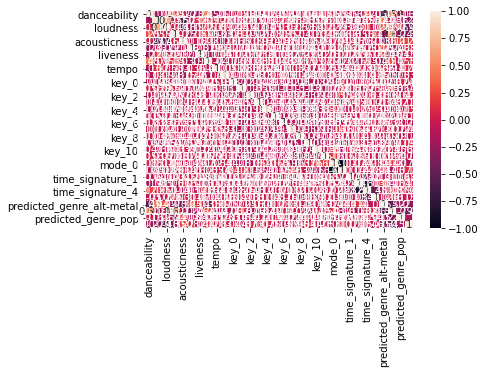

In [8]:
sns.heatmap(pd.get_dummies(all_songs).corr(), annot= True)

In [9]:
len(pd.get_dummies(all_songs).columns)

32

In [10]:
((pd.get_dummies(all_songs).corr()>.75).sum().values).sum()

32

In [11]:
neigh = NearestNeighbors(n_neighbors=10, radius=0.45, metric='cosine')

In [12]:
X_knn = all_songs

In [13]:
MMScaler = preprocessing.MinMaxScaler()
MinMaxScaler = preprocessing.MinMaxScaler()
X_knn[numerical_columns] = MinMaxScaler.fit_transform(X_knn[numerical_columns])


In [14]:
ohe_knn = OneHotEncoder(drop='first', sparse=False)
X_knn_ohe = ohe_knn.fit_transform(X_knn[categorical_columns])
X_knn_transformed = X_knn[numerical_columns].reset_index().join(pd.DataFrame(X_knn_ohe, columns = ohe_knn.get_feature_names(categorical_columns))).set_index('id')


In [15]:
neigh.fit(X_knn_transformed)

NearestNeighbors(metric='cosine', n_neighbors=10, radius=0.45)

In [16]:
categorical_columns

['key', 'mode', 'time_signature', 'predicted_genre']

In [17]:
def knn_preprocessing(sp, key, num_col = numerical_columns, 
                      cat_col = categorical_columns,
                      mmScaler = MinMaxScaler, bm = best_model,
                      ohe_knn = ohe_knn, ohe_make_genre_pred = ohe_make_genre_pred):
    row = song_to_df(sp, key)
    genre = make_genre_prediction(sp,key, ohe_make_genre_pred, bm)
    row['predicted_genre'] = genre[0]
    row_dummied = ohe_knn.transform(row[cat_col])
    row[num_col] = mmScaler.transform(row[num_col])

    row = row[num_col].reset_index().join(pd.DataFrame(row_dummied, columns = ohe_knn.get_feature_names(cat_col))).set_index('id')
    return row

In [18]:
def make_song_recommendations(sp, kneighs, query):
    if(query.isspace() or not query):
        return "No results found"
    song_id = song_id_from_query(sp, query)
    if(song_id == None):
        return "No results found"
    song_plus_artist = song_artist_from_key(sp, song_id)
    song_to_rec = knn_preprocessing(sp, song_id)
    nbrs = neigh.kneighbors(
       song_to_rec, 15, return_distance=False
    )
    playlist = []
    for each in nbrs[0]:
        the_rec_song = song_artist_from_key(sp, X_knn_transformed.iloc[each].name)
        if (((the_rec_song[0:2]) != song_plus_artist[0:2]) and
           ((the_rec_song[0:2]) not in playlist)):
            playlist.append(song_artist_from_key(sp, X_knn_transformed.iloc[each].name))
    return (playlist)

In [26]:
song_id_from_query(sp, "shake it off taylor swift")

'5xTtaWoae3wi06K5WfVUUH'

In [27]:
song_artist_from_key(sp, '5xTtaWoae3wi06K5WfVUUH')

('Shake It Off',
 'Taylor Swift',
 'https://open.spotify.com/track/5xTtaWoae3wi06K5WfVUUH')

In [28]:
make_genre_prediction(sp, '5xTtaWoae3wi06K5WfVUUH', ohe_make_genre_pred, best_model)[0]

'hip-hop'

In [29]:
make_song_recommendations(sp, neigh, "shake it off taylor swift")

[("We Didn't Start the Fire",
  'Billy Joel',
  'https://open.spotify.com/track/38bDGWuyYdSdNfrFfbCiVS'),
 ("Really Don't Care",
  'Demi Lovato',
  'https://open.spotify.com/track/5vTPxzm4h2bY9rYyVrGEU5'),
 ('This Is The Shack',
  'Warren G',
  'https://open.spotify.com/track/0RDpUBXzF6AsCr8gUCXWGK'),
 ('Cash Money Millionaires',
  'Lil Wayne',
  'https://open.spotify.com/track/1tAl34tn79rZn8t1E9EbaN'),
 ('FBC',
  'Freddie Gibbs',
  'https://open.spotify.com/track/4vsV24dkNq93j2mewVMAS5'),
 ('Dopeman',
  'Mack 10',
  'https://open.spotify.com/track/0ebBL0GkRU2MV373996z8g'),
 ("Let's Get Lost (feat. Devon Baldwin) - Teklife Remix",
  'G-Eazy',
  'https://open.spotify.com/track/0HenVYI9rNIKEgJ3PXtkkS'),
 ('Talk to Me',
  'Run The Jewels',
  'https://open.spotify.com/track/0CBLqGc1esSZ5dM2gOZHsU'),
 ('Rhonda',
  'Pastor Troy',
  'https://open.spotify.com/track/48aUzwZD3AbtKDBgcqrz7c'),
 ('The Heat',
  'Lil Wayne',
  'https://open.spotify.com/track/57bIFs9ipfzIHMZYl24OXD'),
 ('On That Sht 